In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.model_selection import train_test_split

from convexmtl_torch.model.ConvexMTLPytorchModel import ConvexMTLPytorchRegressor
from convexmtl_torch.model.GraphLaplacianMTLPytorchModel import GraphLaplacianMTLPytorchRegressor

from convexmtl_torch.model.utils import NeuralNetwork

from sklearn.model_selection import GridSearchCV

from convexmtl_torch.data.MTLSyntheticDataset import MTLCommonRegression

import torch
from torch.nn import MSELoss
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer

from icecream import ic

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from copy import copy

from utils import train_gs

import random


In [2]:
max_epochs=50
log_every_n_steps=10
problem = 'common'

In [3]:
seed = 1

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [4]:
mtlds = MTLCommonRegression(n_samples_per_task=100)

X, y = mtlds.X, mtlds.y

if y.ndim < 2:
    y = y[:, None]

ic| tasks: [0, 1, 2]
ic| colors: {0: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
             1: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
             2: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)}
ic| X_data.shape: (300, 1)


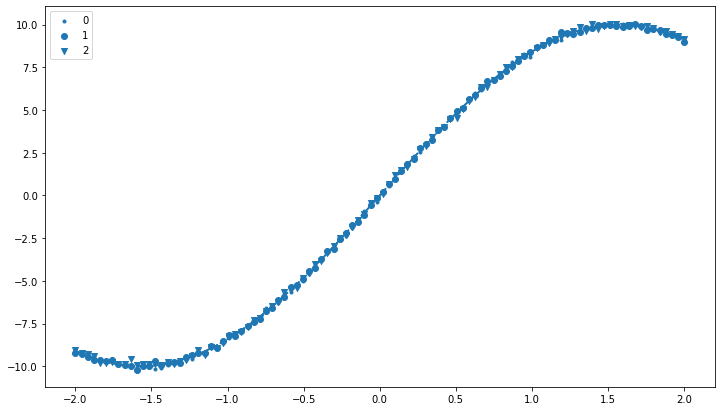

In [5]:
mtlds.plot_data_functions(X, y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_test_numpy = copy(X_test)

In [7]:
X_train.shape

(201, 2)

## ConvexMTL Torch

In [8]:
model = ConvexMTLPytorchRegressor(lambda_trainable=True, specific_lambda=True, train_mode='lightning', epochs=50, batch_size=32, val_size=0.1)
model

ConvexMTLPytorchRegressor(batch_size=32, epochs=50, lambda_trainable=True,
                          specific_lambda=True, train_mode='lightning',
                          val_size=0.1)

In [9]:
model.fit(X_train, y_train)

ic| opt_kwargs: {'lr': 0.001, 'weight_decay': 0.01}
ic| X_train.shape: torch.Size([180, 1])
ic| self.train_mode: 'lightning'
ic| self.epochs: 50
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
ic| trainer: <pytorch_lightning.trainer.trainer.Trainer object at 0x7f016ff87460>
ic| self.val: True
/home/carlos/anaconda3/envs/rkm/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
ic| opt_kwargs: {'lr': 0.001, 'weight_decay': 0.01}

  | Name           | Type          | Params
-------------------------------------------------
0 | common_module_ | NeuralNetwork | 8.5 K 
-------------------------------------------------
8.5 K     Trainable params
0         Non-trainabl

Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 17.11it/s, loss=0.311, v_num=317]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 14.91it/s, loss=0.311, v_num=317]


In [10]:
pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_squared_error(pred, y_test)

0.25208056971693454

In [11]:
wd_l = [10**(k) for k in range(-2, -1)]
lamblr_l = [10**(k) for k in range(-2, -1)]

params = {
    'weight_decay' : wd_l,
    # 'lambda_lr' : lamblr_l,
}
params

{'weight_decay': [0.01]}

In [12]:
gs = train_gs(model, params, X_train, y_train, model_name='convexmtlNN', problem_name=problem, scoring='neg_mean_squared_error', retrain=False)
gs

GridSearchCV(estimator=ConvexMTLPytorchRegressor(batch_size=32, epochs=50,
                                                 lambda_trainable=True,
                                                 specific_lambda=True,
                                                 train_mode='lightning',
                                                 val_size=0.1),
             param_grid={'weight_decay': [0.01]},
             scoring='neg_mean_squared_error')

In [13]:
gs.best_estimator_.fit(X_train, y_train)

ic| opt_kwargs: {'lr': 0.001, 'weight_decay': 0.01}
ic| X_train.shape: torch.Size([180, 1])
ic| self.train_mode: 'lightning'
ic| self.epochs: 50
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
ic| trainer: <pytorch_lightning.trainer.trainer.Trainer object at 0x7f016d07d040>
ic| self.val: True
/home/carlos/anaconda3/envs/rkm/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
ic| opt_kwargs: {'lr': 0.001, 'weight_decay': 0.01}

  | Name           | Type          | Params
-------------------------------------------------
0 | common_module_ | NeuralNetwork | 8.5 K 
-------------------------------------------------
8.5 K     Trainable params
0         Non-trainabl

Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 27.13it/s, loss=0.255, v_num=318]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 23.72it/s, loss=0.255, v_num=318]


In [14]:
gs.best_params_

{'weight_decay': 0.01}

In [15]:
pred = gs.best_estimator_.predict(X_test)

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_squared_error(pred, y_test)

0.22672863451499883

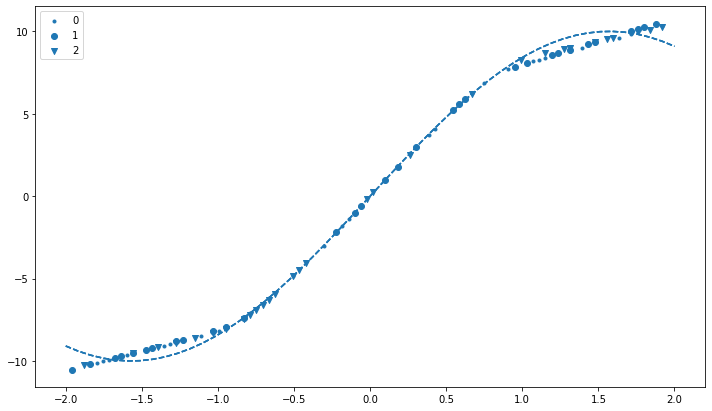

In [17]:
mtlds.plot_data_functions(X_test, pred)

In [18]:
gs.best_estimator_.model.get_lamb()

ic| self.lamb_dic: {0: Parameter containing:
                   tensor([0.0737], requires_grad=True),
                    1: Parameter containing:
                   tensor([0.0427], requires_grad=True),
                    2: Parameter containing:
                   tensor([0.0733], requires_grad=True)}


{0: array([0.51840544], dtype=float32),
 1: array([0.51066685], dtype=float32),
 2: array([0.5183253], dtype=float32)}

## Tensorboard

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=gl_common_logs/